In [3]:
import os
import numpy as np
import cv2
from skimage.transform import resize
import matplotlib.pyplot as plt

## Load data

In [5]:
integer_to_class = { '1': 'no_lesion (1)', '2': 'lesion (2)' }

NPY_PATH = r"dataset\numpy"

labels = np.load(os.path.join(NPY_PATH,'labels.npy'))
t1w_images = np.load(os.path.join(NPY_PATH,'T1W_images.npy')) / 255.0
t2f_images = np.load(os.path.join(NPY_PATH,'T2F_images.npy')) / 255.0
t2w_images = np.load(os.path.join(NPY_PATH,'T2W_images.npy')) / 255
masks = np.load(os.path.join(NPY_PATH,'Mask_images.npy')) / 255

# Show samples

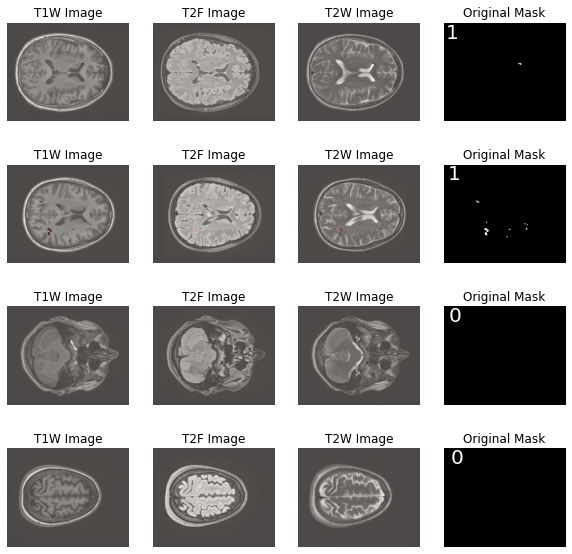

In [7]:
plt.figure(figsize=(10,10))
i=1;total=4
temp = np.ones_like( t1w_images[0] )

for idx in np.random.randint(0,high=t1w_images.shape[0],size=total):
    plt.subplot(total,4,i);i+=1
    plt.imshow(t1w_images[idx], cmap='gray' )
    plt.imshow(masks[idx], alpha=0.3,cmap='Reds')
    plt.title("T1W Image");plt.axis('off')

    plt.subplot(total,4,i);i+=1
    plt.imshow(t2f_images[idx], cmap='gray' )
    plt.imshow(masks[idx], alpha=0.3,cmap='Reds')
    plt.title("T2F Image");plt.axis('off')

    plt.subplot(total,4,i);i+=1
    plt.imshow(t2w_images[idx], cmap='gray' )
    plt.imshow(masks[idx], alpha=0.3,cmap='Reds')
    plt.title("T2W Image");plt.axis('off')
    
    plt.subplot(total,4,i);i+=1
    plt.imshow(masks[idx], cmap='gray' )
    plt.text(i,40, labels[idx], fontsize=20, fontdict=dict(color='white'))
    plt.title("Original Mask");plt.axis('off')

## Resizing

In [9]:
HAS_RESIZING = True

# resizing
img_size_ori = (260,320)
img_size_target = (256,256)

In [11]:
t1w_images = np.expand_dims(t1w_images,axis=-1)
t2f_images = np.expand_dims(t2f_images,axis=-1)
t2w_images = np.expand_dims(t2w_images,axis=-1)
masks = np.expand_dims(masks,axis=-1)

In [ ]:
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target[0], img_size_target[1]), mode='constant', preserve_range=True,)
    
def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori[0], img_size_ori[1]), mode='constant', preserve_range=True)

In [12]:
if HAS_RESIZING:
    t1w_images = np.array([ downsample(image) for image in t1w_images ])
    t2f_images = np.array([ downsample(image) for image in t2f_images ])
    t2w_images = np.array([ downsample(image) for image in t2w_images ])
    masks = (np.array([ downsample(mask) for mask in masks ])>0)*1

i = 1
plt.subplot(1,3,i);i+=1
plt.imshow( np.squeeze(t1w_images[0],axis=-1), cmap='gray' )
plt.title("MRI Image");plt.axis('off')

plt.subplot(1,3,i);i+=1
plt.imshow( np.squeeze(t1w_images[0],axis=-1), cmap='gray' )
plt.imshow( np.squeeze(masks[0],axis=-1), alpha=0.3, cmap='Reds' )
plt.title("Original Mask");plt.axis('off')

ValueError: len(output_shape) cannot be smaller than the image dimensions

In [14]:
from sklearn.model_selection import train_test_split
import gc

image_datasets = np.concatenate((t1w_images,t2f_images,t2w_images),axis=0)
mask_datasets = np.concatenate((masks,masks,masks),axis =0)
labels_datasets = np.concatenate((labels,labels,labels),axis =0)

print(image_datasets.shape)
print(mask_datasets.shape)
print(labels_datasets.shape)

X,X_v,Y,Y_v = train_test_split( image_datasets,mask_datasets,test_size=0.2,stratify=labels_datasets)
del t1w_images
del t2f_images
del t2w_images
del masks
del labels
gc.collect()

print(X.shape)
print(X_v.shape)
print(Y.shape)
print(Y_v.shape)


(7068, 260, 320, 1, 1)
(7068, 260, 320, 1, 1)
(7068,)
(5654, 260, 320, 1, 1)
(1414, 260, 320, 1, 1)
(5654, 260, 320, 1, 1)
(1414, 260, 320, 1, 1)


## Augmentation

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    brightness_range=(0.9,1.1),
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                   zoom_range=[.9,1.1],
                                   fill_mode='nearest')
                                   
val_datagen = ImageDataGenerator()

## U-Net

In [16]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

In [17]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model

IMG_DIM = (256,256,1)

def conv2d_block( input_tensor, n_filters, kernel_size = (3,3), name="contraction"):
  "Add 2 conv layer"
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu", name=name+'_1')(input_tensor)
  
  x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu",name=name+'_2')(x)
  return x
  

inp = Input( shape=IMG_DIM )

d1 = conv2d_block( inp, 64, name="contraction_1")
p1 = MaxPooling2D( pool_size=(2,2), strides=(2,2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block( p1, 128, name="contraction_2_1" )
p2 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block( p2, 256, name="contraction_3_1")
p3 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3,512, name="contraction_4_1")
p4 = MaxPooling2D(pool_size=(2,2), strides=(2,2) )(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4,512, name="contraction_5_1")

u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(d5)
u1 = concatenate([u1,d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
u2 = concatenate([u2,d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
u3 = concatenate([u3,d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
u4 = concatenate([u4,d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4,64, name="expansion_4")

out = Conv2D(1, (1,1), name="output", activation='sigmoid')(c4)

unet = Model( inp, out )
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
contraction_1_1 (Conv2D)        (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
contraction_1_2 (Conv2D)        (None, 256, 256, 64) 36928       contraction_1_1[0][0]            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           contraction_1_2[0][0]            
______________________________________________________________________________________________

# IoU and Compile model

In [18]:
from util import iou_metric,dice_loss, bce_dice_loss
import tensorflow as tf

In [19]:
unet.compile(optimizer=optimizers.Adam(lr=1e-3), 
             loss=bce_dice_loss, metrics=['accuracy',tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou")])

# Train model

In [20]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

In [21]:
model_checkpoint  = ModelCheckpoint('model_best_checkpoint.h5', save_best_only=True, monitor='val_accuracy', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
reduceLR = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss',min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduceLR, model_checkpoint]

hist = unet.fit(
    X,Y,
    batch_size=16,
    validation_data = (X_v,Y_v),
    epochs=100,
    verbose=1,
    callbacks= callback_list
)


Epoch 1/100


ValueError: in user code:

    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\VIP444\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 256, 256, 1), found shape=(None, 260, 320, 1, 1)


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model

unet = load_model('model_best_checkpoint.h5', custom_objects={'bce_dice_loss': bce_dice_loss,'iou_metric':tf.keras.metrics.MeanIoU(num_classes=2,name="mean_iou")}) #or compile = False

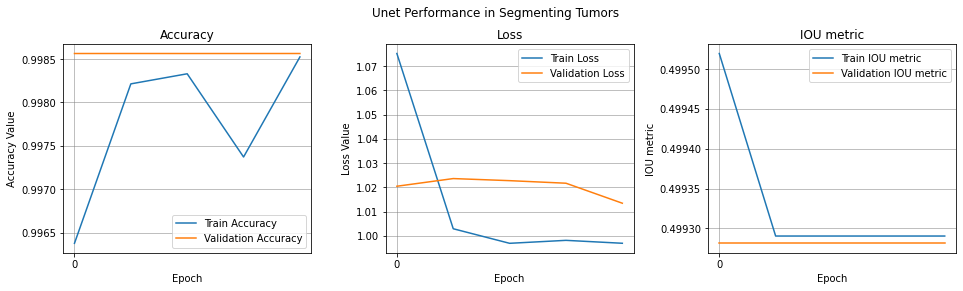

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Unet Performance in Segmenting Tumors', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['mean_iou'], label='Train IOU metric')
ax3.plot(epoch_list, hist.history['val_mean_iou'], label='Validation IOU metric')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('IOU metric');ax3.set_xlabel('Epoch');ax3.set_title('IOU metric')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [18]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou
    
def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

Text(0.5, 1.0, 'Threshold vs IoU (0.09090909090909091, 4.134127637056665e-16)')

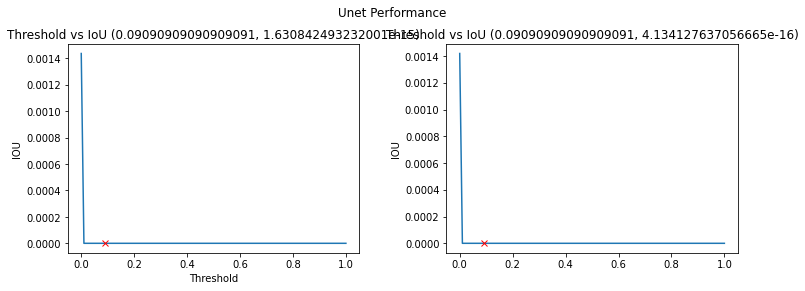

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Unet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

th, ious, iou_best, th_best = getIOUCurve(Y_v,unet.predict(X_v))
ax1.plot(th, ious,label="For Validation")
ax1.plot(th_best, iou_best, "xr", label="Best threshold")
ax1.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax1.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

th, ious, iou_best, th_best = getIOUCurve(Y,unet.predict(X))
ax2.plot(th, ious, label="For Training")
ax2.plot(th_best, iou_best, "xr", label="Best threshold")
ax2.set_ylabel('IOU');ax1.set_xlabel('Threshold')
ax2.set_title("Threshold vs IoU ({}, {})".format(th_best, iou_best))

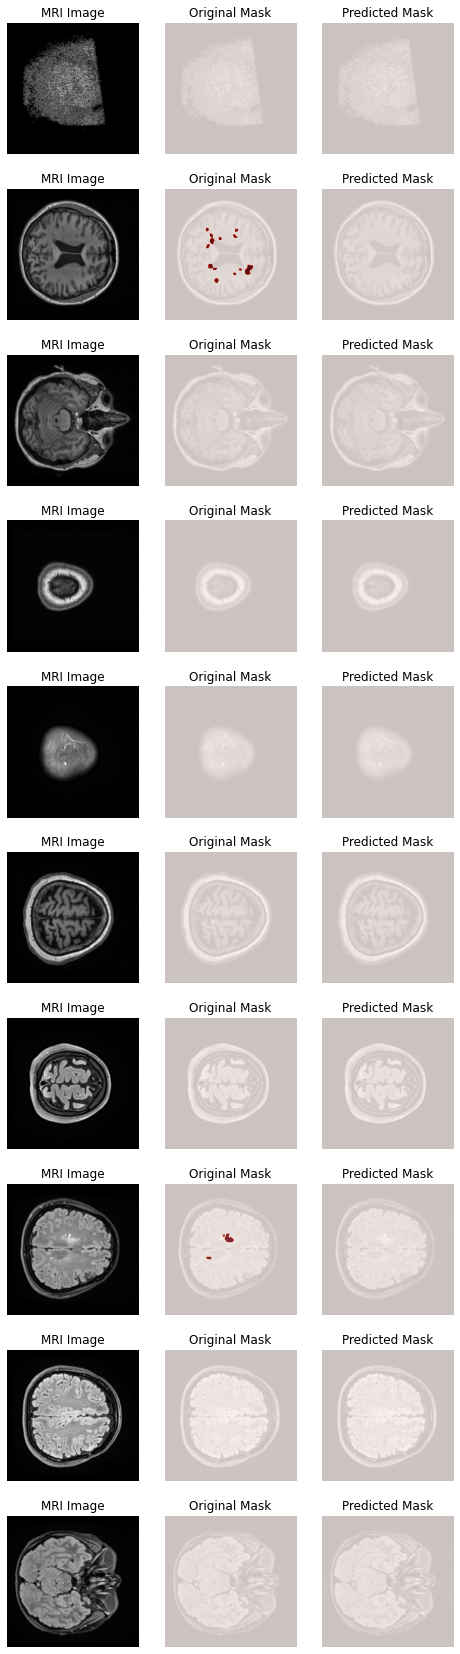

In [21]:
THRESHOLD = 0.2
predicted_mask = (unet.predict(image_datasets)>THRESHOLD)*1

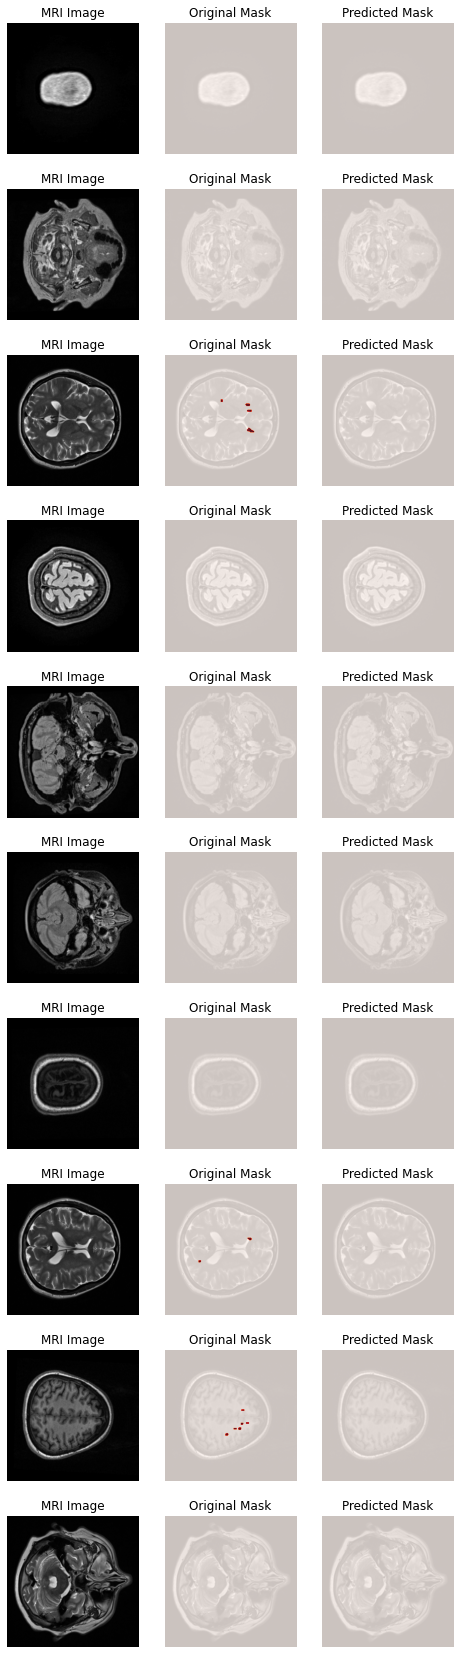

In [22]:
i=1;total=20
temp = np.ones_like( Y_v[0] )

plt.figure(figsize=(8,60))
for idx in np.random.randint(0,high=X_v.shape[0],size=total):
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.title("MRI Image");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(Y_v[idx],axis=-1), alpha=0.8, cmap='Reds' )
    plt.title("Original Mask");plt.axis('off')
    
    plt.subplot(total,3,i);i+=1
    plt.imshow( np.squeeze(X_v[idx],axis=-1), cmap='gray' )
    plt.imshow( np.squeeze(predicted_mask[idx],axis=-1),  alpha=0.8, cmap='Reds' )
    plt.title("Predicted Mask");plt.axis('off')